# 1. Instalação bibliotecas e download do dataset do kaggle

In [2]:
!pip install opendatasets
!pip install pandas
!pip install imagehash

!pip install torch torchvision -q # Instala o PyTorch

!pip install segmentation-models-pytorch -q # Instala a biblioteca segmentation-models-pytorch

!pip install "numpy>=2.0" albumentations -q# Instala o Albumentations (Biblioteca poderosa para Aumento de Dados)




   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.7/296.7 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 3.2 MB/s eta 0:00:00
/bin/bash: -c: line 1: syntax error near unexpected token `('
/bin/bash: -c: line 1: `pip install "numpy>=2.0" albumentations -q# Instala o Albumentations (Biblioteca poderosa para Aumento de Dados)'


In [3]:
!pip install --upgrade albumentations

In [4]:
import os
import pandas as pd
from PIL import Image, ImageOps
import opendatasets as od
import matplotlib.pyplot as plt
import seaborn as sns
import imagehash
import hashlib
import numpy as np
import time
from collections import defaultdict
from IPython.display import display
from tqdm import tqdm
from sklearn.metrics import confusion_matrix


# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Segmentation Models Pytorch (smp)
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss, FocalLoss

# OpenCV e Albumentations (Manipulação e Aumento de Dados)
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2





In [5]:
od.download("https://www.kaggle.com/datasets/carlolepelaars/camvid")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: elomarin
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/carlolepelaars/camvid


100%|██████████| 575M/575M [00:03<00:00, 194MB/s]


# 2. Verificação da quantidade de imagens e máscaras por pasta

In [6]:

dir_test = "/content/camvid/CamVid/test"
dir_test_labels = "/content/camvid/CamVid/test_labels"
dir_train = "/content/camvid/CamVid/train"
dir_train_labels = "/content/camvid/CamVid/train_labels"
dir_val = "/content/camvid/CamVid/val"
dir_val_labels = "/content/camvid/CamVid/val_labels"

dir_test_num = len(os.listdir(dir_test))
dir_test_labels_num = len(os.listdir(dir_test_labels))
dir_train_num = len(os.listdir(dir_train))
dir_train_labels_num = len(os.listdir(dir_train_labels))
dir_val_num = len(os.listdir(dir_val))
dir_val_labels_num = len(os.listdir(dir_val_labels))

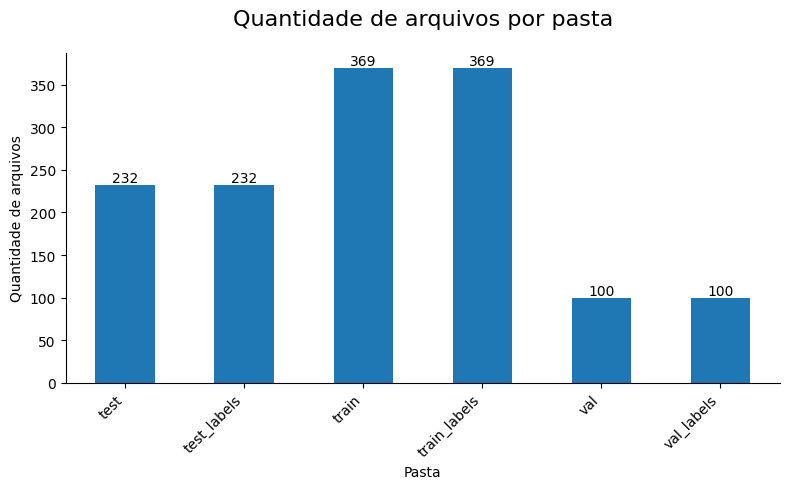

<Figure size 640x480 with 0 Axes>

In [7]:

data = {
    'Quantidade de arquivos': [dir_test_num, dir_test_labels_num, dir_train_num, dir_train_labels_num, dir_val_num, dir_val_labels_num]
}
index = ['test', 'test_labels', 'train', 'train_labels', 'val', 'val_labels']
df = pd.DataFrame(data, index=index)


plt.figure(figsize=(8, 5))
ax = df['Quantidade de arquivos'].plot(kind='bar', legend=False)
plt.title('Quantidade de arquivos por pasta',  fontsize=16, pad=20)
plt.xlabel('Pasta')
plt.ylabel('Quantidade de arquivos')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
for container in ax.containers:
    ax.bar_label(container)

sns.despine()
plt.grid(False)
plt.show()
plt.savefig("qntd_arquivo_por_pasta.png", format = "png")

# 3. Verificando formato dos arquivos

In [8]:
def verificar_formato(dir):
  formatos = {}
  erros = []

  for arquivo in os.listdir(dir):
    caminho_completo = os.path.join(dir, arquivo)

    if os.path.isdir(caminho_completo):
      continue

    try:
      img = Image.open(caminho_completo)
      formato = img.format

      if formato in formatos:
        formatos[formato] += 1
      else:
        formatos[formato] = 1

    except Exception as e:
      erros.append(f'Erro ao abrir {arquivo}: {e}')

  return formatos,erros

In [9]:
def verificar_formato(dir):
  formatos = {}
  erros = []

  for arquivo in os.listdir(dir):
    caminho_completo = os.path.join(dir, arquivo)

    if os.path.isdir(caminho_completo):
      continue

    try:
      img = Image.open(caminho_completo)
      formato = img.format

      if formato in formatos:
        formatos[formato] += 1
      else:
        formatos[formato] = 1

    except Exception as e:
      erros.append(f'Erro ao abrir {arquivo}: {e}')

  return formatos,erros

def processar_diretorios_para_tabela(diretorios):
    todos_formatos = {}
    todos_erros = []

    for nome_diretorio, caminho_diretorio in diretorios.items():
        formatos, erros = verificar_formato(caminho_diretorio)
        todos_erros.extend(erros)

        for formato, quantidade in formatos.items():
            if nome_diretorio not in todos_formatos:
                todos_formatos[nome_diretorio] = {}
            todos_formatos[nome_diretorio][formato] = quantidade

    if todos_erros:
        print('Arquivos com erro:')
        for erro in todos_erros:
            print(erro)

    if todos_formatos:
        df_formatos = pd.DataFrame(todos_formatos).fillna(0).T
        df_formatos['Total'] = df_formatos.sum(axis=1)
        print("Formatos de Arquivo por Pasta")
        display(df_formatos)


diretorios = {
    'test': dir_test,
    'test_labels': dir_test_labels,
    'train': dir_train,
    'train_labels': dir_train_labels,
    'val': dir_val,
    'val_labels': dir_val_labels
}

processar_diretorios_para_tabela(diretorios)

Formatos de Arquivo por Pasta


,PNG,Total
test,232,232
test_labels,232,232
train,369,369
train_labels,369,369
val,100,100
val_labels,100,100


# 4. Verificação de valores ausentes

In [10]:
caminho_class_dict = "/content/camvid/CamVid/class_dict.csv"

try:
    df_class_dict = pd.read_csv(caminho_class_dict)
    print(f"Conteúdo do arquivo: {caminho_class_dict}")
    display(df_class_dict)
except FileNotFoundError:
    print(f"Erro: O arquivo {caminho_class_dict} não foi encontrado.")
except Exception as e:
    print(f"Ocorreu um erro ao ler o arquivo {caminho_class_dict}: {e}")

Conteúdo do arquivo: /content/camvid/CamVid/class_dict.csv


,name,r,g,b
0,Animal,64,128,64
1,Archway,192,0,128
2,Bicyclist,0,128,192
3,Bridge,0,128,64
4,Building,128,0,0
5,Car,64,0,128
6,CartLuggagePram,64,0,192
7,Child,192,128,64
8,Column_Pole,192,192,128
9,Fence,64,64,128


In [11]:
# Verificar valores ausentes no DataFrame df_class_dict
valores_ausentes = df_class_dict.isnull().sum()

print("Valores ausentes no DataFrame df_class_dict:")
display(valores_ausentes)

Valores ausentes no DataFrame df_class_dict:


,0
name,0
r,0
g,0
b,0


# 5. Verificação de inconsistência nas imagens

In [12]:
#Verificando dimensões das imagens
def verificar_dimensoes_imagens_df(diretorio):
    dimensoes_contagem = {}
    erros_abrir = 0

    arquivos = os.listdir(diretorio)
    if not arquivos:
        return {'diretorio': diretorio}

    # Verificar as dimensões de todas as imagens
    for arquivo in arquivos:
        caminho_completo = os.path.join(diretorio, arquivo)
        if os.path.isdir(caminho_completo):
            continue
        try:
            with Image.open(caminho_completo) as img:
                dimensao = img.size
                if dimensao in dimensoes_contagem:
                    dimensoes_contagem[dimensao] += 1
                else:
                    dimensoes_contagem[dimensao] = 1
        except Exception as e:
             erros_abrir += 1

    return {'diretorio': diretorio, **dimensoes_contagem}


# Coletar informações de dimensões de todos os diretórios de imagens e máscaras
print("Verificando dimensões das imagens e máscaras:")

resultados_dimensoes = []
resultados_dimensoes.append(verificar_dimensoes_imagens_df(dir_test))
resultados_dimensoes.append(verificar_dimensoes_imagens_df(dir_test_labels))
resultados_dimensoes.append(verificar_dimensoes_imagens_df(dir_train))
resultados_dimensoes.append(verificar_dimensoes_imagens_df(dir_train_labels))
resultados_dimensoes.append(verificar_dimensoes_imagens_df(dir_val))
resultados_dimensoes.append(verificar_dimensoes_imagens_df(dir_val_labels))

# Criar DataFrame a partir dos resultados coletados
df_dimensoes = pd.DataFrame(resultados_dimensoes)

# Extrair apenas o último nome do diretório
df_dimensoes['Nome_do_diretorio'] = df_dimensoes['diretorio'].apply(lambda x: os.path.basename(x))

# Remover a coluna original 'diretorio'
df_dimensoes = df_dimensoes.drop('diretorio', axis=1)

# Reordenar as colunas para colocar 'Nome_do_diretorio' como a primeira coluna
cols = ['Nome_do_diretorio'] + [col for col in df_dimensoes.columns if col != 'Nome_do_diretorio']
df_dimensoes = df_dimensoes[cols]

print("\nResumo das dimensões das imagens por diretório:")
display(df_dimensoes)

Verificando dimensões das imagens e máscaras:

Resumo das dimensões das imagens por diretório:


,Nome_do_diretorio,"(960, 720)"
0,test,232
1,test_labels,232
2,train,369
3,train_labels,369
4,val,100
5,val_labels,100



Coluna de dimensão encontrada: (960, 720)


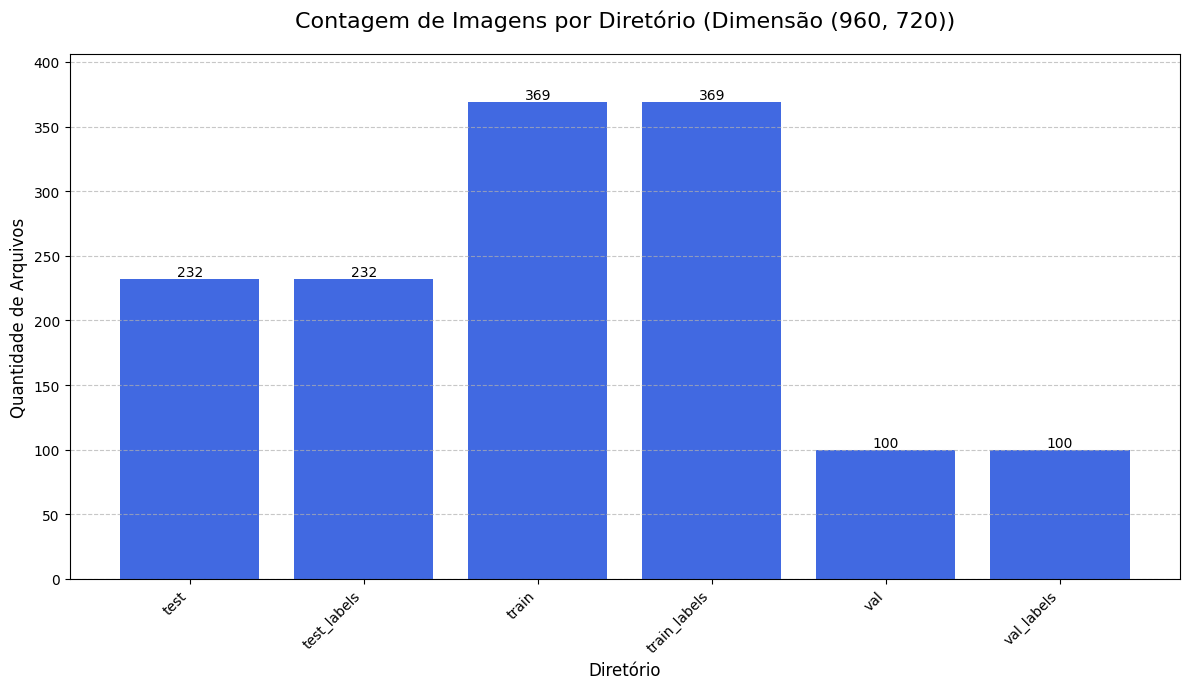

In [13]:
dimension_column = None
for col in df_dimensoes.columns:

    if isinstance(col, tuple):
        dimension_column = col
        print(f"\nColuna de dimensão encontrada: {dimension_column}")
        break

if dimension_column is not None:
    plt.figure(figsize=(12, 7))


    bars = plt.bar(
        df_dimensoes['Nome_do_diretorio'],
        df_dimensoes[dimension_column],
        color='royalblue'
    )
    plt.bar_label(bars, fmt='%d')


    plt.title(f'Contagem de Imagens por Diretório (Dimensão {dimension_column})',  fontsize=16, pad=20)
    plt.xlabel('Diretório', fontsize=12)
    plt.ylabel('Quantidade de Arquivos', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.ylim(top=df_dimensoes[dimension_column].max() * 1.1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print("\nGráfico não gerado: Nenhuma coluna de dimensão foi encontrada no DataFrame.")

## 6. Verificação de dados corrompidos

In [14]:
def find_corrupted_images(directory):

    corrupted_images = []
    for filename in os.listdir(directory):
        filepath = os.path.join(directory, filename)
        if os.path.isdir(filepath):
            continue  # Skip directories
        try:
            # Attempt to open and close the image
            with Image.open(filepath) as img:
                img.verify() # Verify that the file is an image
        except Exception as e:
            corrupted_images.append({'arquivo': filename, 'diretorio': directory, 'erro': str(e)})
    return corrupted_images

# Directories to check
image_directories = [
    dir_test,
    dir_train,
    dir_val,
    dir_test_labels,
    dir_train_labels,
    dir_val_labels
]

all_corrupted_images = []
print("Verificando imagens corrompidas:")
for directory in image_directories:
    print(f"Verificando diretório: {directory}")
    corrupted_images_in_dir = find_corrupted_images(directory)
    all_corrupted_images.extend(corrupted_images_in_dir)

if all_corrupted_images:
    print("\nImagens corrompidas encontradas:")
    df_corrupted = pd.DataFrame(all_corrupted_images)
    display(df_corrupted)
else:
    print("\nNão foram encontradas imagens corrompidas em nenhum dos diretórios.")

Verificando imagens corrompidas:
Verificando diretório: /content/camvid/CamVid/test
Verificando diretório: /content/camvid/CamVid/train
Verificando diretório: /content/camvid/CamVid/val
Verificando diretório: /content/camvid/CamVid/test_labels
Verificando diretório: /content/camvid/CamVid/train_labels
Verificando diretório: /content/camvid/CamVid/val_labels

Não foram encontradas imagens corrompidas em nenhum dos diretórios.


## 7. Distribuição das classes

In [15]:
def check_class_presence(image_path, class_mapping):
    """Checks which classes are present in a mask image."""
    present_classes = set()
    try:
        img = Image.open(image_path).convert('RGB')
        img_array = np.array(img)

        for color, name in class_mapping.items():
            # Check if the color is present in the image array
            if np.any(np.all(img_array == color, axis=-1)):
                present_classes.add(name)

    except Exception as e:
        print(f"Erro ao processar a imagem {image_path}: {e}")

    return present_classes

# Load the class dictionary
caminho_class_dict = "/content/camvid/CamVid/class_dict.csv"
try:
    df_class_dict = pd.read_csv(caminho_class_dict)
    # Create a mapping from color tuple to class name
    class_mapping = {tuple(row[['r', 'g', 'b']].values): row['name'] for index, row in df_class_dict.iterrows()}
except FileNotFoundError:
    print(f"Erro: O arquivo {caminho_class_dict} não foi encontrado.")
    class_mapping = {}
except Exception as e:
    print(f"Ocorreu um erro ao ler o arquivo {caminho_class_dict}: {e}")
    class_mapping = {}


# Directory containing the label images
dir_test_labels = "/content/camvid/CamVid/test_labels"

# Initialize a dictionary to store the count of images where each class appears
class_image_counts = {}

if class_mapping:
    # Initialize counts for all classes to 0
    for name in class_mapping.values():
        class_image_counts[name] = 0

    # Iterate through each label image in the directory
    for filename in os.listdir(dir_test_labels):
        if filename.endswith(".png"): # Assuming label images are PNGs
            image_path = os.path.join(dir_test_labels, filename)
            present_classes = check_class_presence(image_path, class_mapping)

            # Increment the count for each present class
            for class_name in present_classes:
                class_image_counts[class_name] += 1

    # Create a DataFrame from the image counts and rank them
    if class_image_counts:
        df_ranking_images = pd.DataFrame(list(class_image_counts.items()), columns=['Classe', 'Número de Imagens'])
        df_ranking_images = df_ranking_images.sort_values(by='Número de Imagens', ascending=False).reset_index(drop=True)
        df_ranking_images.index = df_ranking_images.index + 1 # Start ranking from 1

        print("\nRanking de Classes por Número de Imagens nas Máscaras de Teste:")
        display(df_ranking_images)
    else:
        print("\nNenhuma classe encontrada nas máscaras de teste.")
else:
    print("\nMapeamento de classes não disponível. Não é possível gerar o ranking.")


Ranking de Classes por Número de Imagens nas Máscaras de Teste:


,Classe,Número de Imagens
1,Column_Pole,232
2,Void,232
3,Sky,232
4,Road,232
5,LaneMkgsDriv,231
6,Building,226
7,Sidewalk,224
8,Car,220
9,Pedestrian,218
10,Tree,216


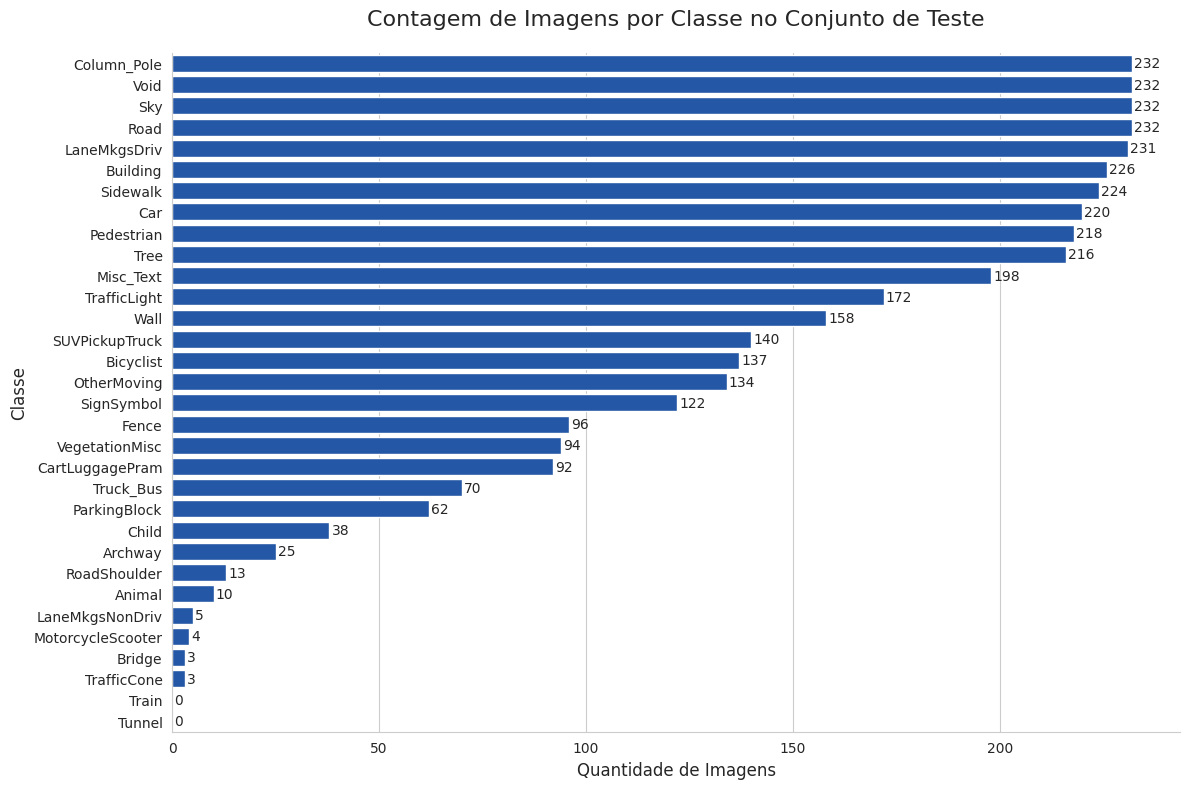

In [16]:
df_ranking_images = pd.DataFrame(list(class_image_counts.items()), columns=['Classe', 'Número de Imagens'])
# Ordenando os dados para a visualização no gráfico
df_plot = df_ranking_images.sort_values(by='Número de Imagens', ascending=False)

# Configurações do estilo e tamanho do gráfico
sns.set_style("whitegrid")
plt.figure(figsize=(12, 8))

# Criação do gráfico de barras horizontais
ax = sns.barplot(x='Número de Imagens', y='Classe', data=df_plot, color='#0F52BA', orient='h')


# As linhas abaixo devem estar no mesmo nível de indentação que a linha 'ax = sns.barplot(...)'

# Adicionando Título e Rótulos
ax.set_title('Contagem de Imagens por Classe no Conjunto de Teste', fontsize=16, pad=20)
ax.set_xlabel('Quantidade de Imagens', fontsize=12)
ax.set_ylabel('Classe', fontsize=12)

# Adicionando os valores exatos ao lado de cada barra
for p in ax.patches:

  width = p.get_width()
  ax.text(width + 0.5,
  p.get_y() + p.get_height() / 2.,
  f'{int(width)}',
  ha='left',
  va='center',
  fontsize=10)

# Removendo as bordas superior e direita do gráfico para um visual mais limpo
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Ajustando o layout e exibindo o gráfico
plt.tight_layout()
plt.show()

In [17]:
# Directory containing the training label images
dir_train_labels = "/content/camvid/CamVid/train_labels"

# Initialize a dictionary to store the count of images where each class appears in the training set
train_class_image_counts = {}

if class_mapping:
    # Initialize counts for all classes to 0
    for name in class_mapping.values():
        train_class_image_counts[name] = 0

    # Iterate through each label image in the training directory
    print(f"Analisando distribuição de classes no diretório: {dir_train_labels}")
    for filename in os.listdir(dir_train_labels):
        if filename.lower().endswith(".png"): # Assuming label images are PNGs and case-insensitive
            image_path = os.path.join(dir_train_labels, filename)
            # Use the existing check_class_presence function
            present_classes = check_class_presence(image_path, class_mapping)

            # Increment the count for each present class
            for class_name in present_classes:
                train_class_image_counts[class_name] += 1

    # Create a DataFrame from the image counts and rank them
    if train_class_image_counts:
        df_train_ranking_images = pd.DataFrame(list(train_class_image_counts.items()), columns=['Classe', 'Número de Imagens'])
        df_train_ranking_images = df_train_ranking_images.sort_values(by='Número de Imagens', ascending=False).reset_index(drop=True)
        df_train_ranking_images.index = df_train_ranking_images.index + 1 # Start ranking from 1

        print("\nRanking de Classes por Número de Imagens nas Máscaras de Treino:")
        display(df_train_ranking_images)

        # You can also create a bar plot similar to the test set if needed
        # Code for plotting would go here (similar to cell 3kloS2zzZ7Tt, but using df_train_ranking_images)

    else:
        print("\nNenhuma classe encontrada nas máscaras de treino.")
else:
    print("\nMapeamento de classes não disponível. Não é possível gerar o ranking para o conjunto de treino.")

Analisando distribuição de classes no diretório: /content/camvid/CamVid/train_labels

Ranking de Classes por Número de Imagens nas Máscaras de Treino:


,Classe,Número de Imagens
1,Void,369
2,Road,369
3,Column_Pole,367
4,Sky,367
5,LaneMkgsDriv,366
6,Building,363
7,Sidewalk,353
8,Car,333
9,Pedestrian,332
10,Tree,329


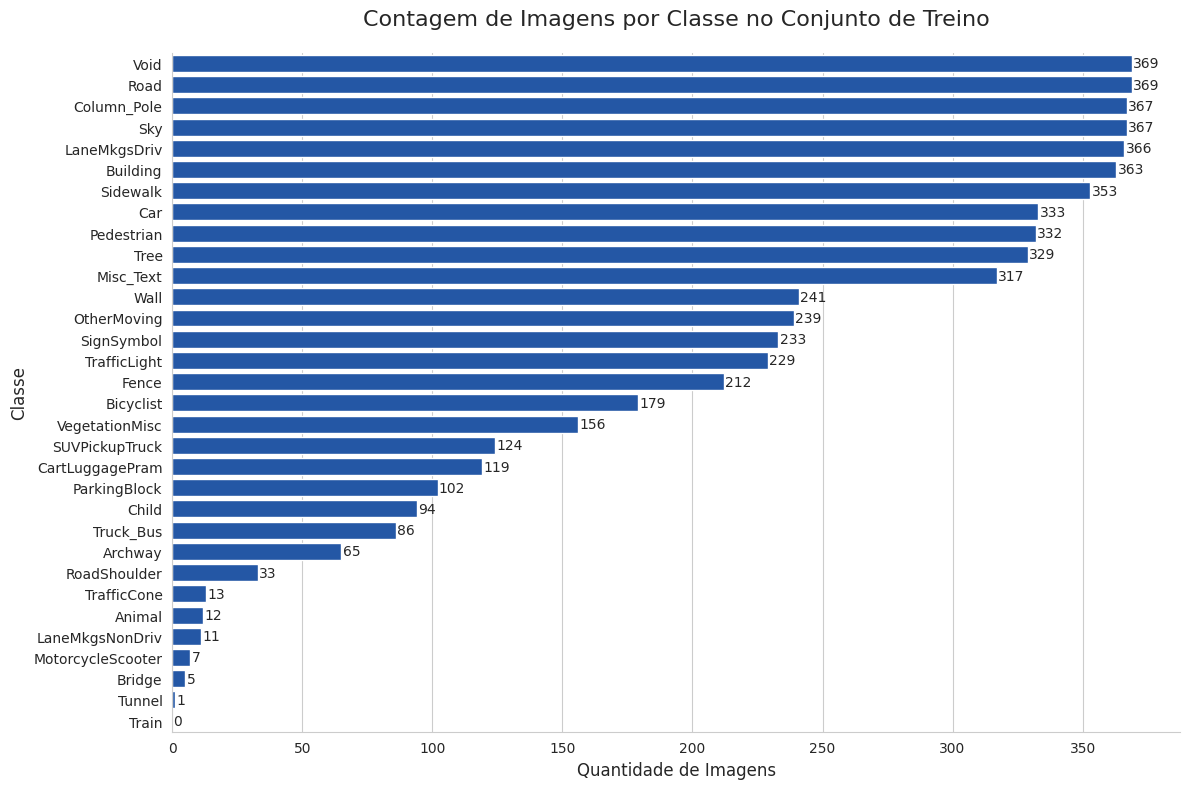

In [18]:
# Ordenando os dados para a visualização no gráfico
df_train_plot = df_train_ranking_images.sort_values(by='Número de Imagens', ascending=False)

# Configurações do estilo e tamanho do gráfico
sns.set_style("whitegrid")
plt.figure(figsize=(12, 8))

# Criação do gráfico de barras horizontais
ax = sns.barplot(x='Número de Imagens', y='Classe', data=df_train_plot, color='#0F52BA', orient='h')

# Adicionando Título e Rótulos
ax.set_title('Contagem de Imagens por Classe no Conjunto de Treino', fontsize=16, pad=20)
ax.set_xlabel('Quantidade de Imagens', fontsize=12)
ax.set_ylabel('Classe', fontsize=12)

# Adicionando os valores exatos ao lado de cada barra
for p in ax.patches:
  width = p.get_width()
  ax.text(width + 0.5,
          p.get_y() + p.get_height() / 2.,
          f'{int(width)}',
          ha='left',
          va='center',
          fontsize=10)

# Removendo as bordas superior e direita do gráfico para um visual mais limpo
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Ajustando o layout e exibindo o gráfico
plt.tight_layout()
plt.show()

In [19]:
# Directory containing the validation label images
dir_val_labels = "/content/camvid/CamVid/val_labels"

# Initialize a dictionary to store the count of images where each class appears in the validation set
val_class_image_counts = {}

if class_mapping:
    # Initialize counts for all classes to 0
    for name in class_mapping.values():
        val_class_image_counts[name] = 0

    # Iterate through each label image in the validation directory
    print(f"Analisando distribuição de classes no diretório: {dir_val_labels}")
    for filename in os.listdir(dir_val_labels):
        if filename.lower().endswith(".png"): # Assuming label images are PNGs and case-insensitive
            image_path = os.path.join(dir_val_labels, filename)
            # Use the existing check_class_presence function
            present_classes = check_class_presence(image_path, class_mapping)

            # Increment the count for each present class
            for class_name in present_classes:
                val_class_image_counts[class_name] += 1

    # Create a DataFrame from the image counts and rank them
    if val_class_image_counts:
        df_val_ranking_images = pd.DataFrame(list(val_class_image_counts.items()), columns=['Classe', 'Número de Imagens'])
        df_val_ranking_images = df_val_ranking_images.sort_values(by='Número de Imagens', ascending=False).reset_index(drop=True)
        df_val_ranking_images.index = df_val_ranking_images.index + 1 # Start ranking from 1

        print("\nRanking de Classes por Número de Imagens nas Máscaras de Validação:")
        display(df_val_ranking_images)

    else:
        print("\nNenhuma classe encontrada nas máscaras de validação.")
else:
    print("\nMapeamento de classes não disponível. Não é possível gerar o ranking para o conjunto de validação.")

Analisando distribuição de classes no diretório: /content/camvid/CamVid/val_labels

Ranking de Classes por Número de Imagens nas Máscaras de Validação:


,Classe,Número de Imagens
1,Column_Pole,100
2,Void,100
3,Sky,100
4,Road,100
5,LaneMkgsDriv,99
6,Building,98
7,Sidewalk,95
8,Tree,92
9,Pedestrian,90
10,Car,90


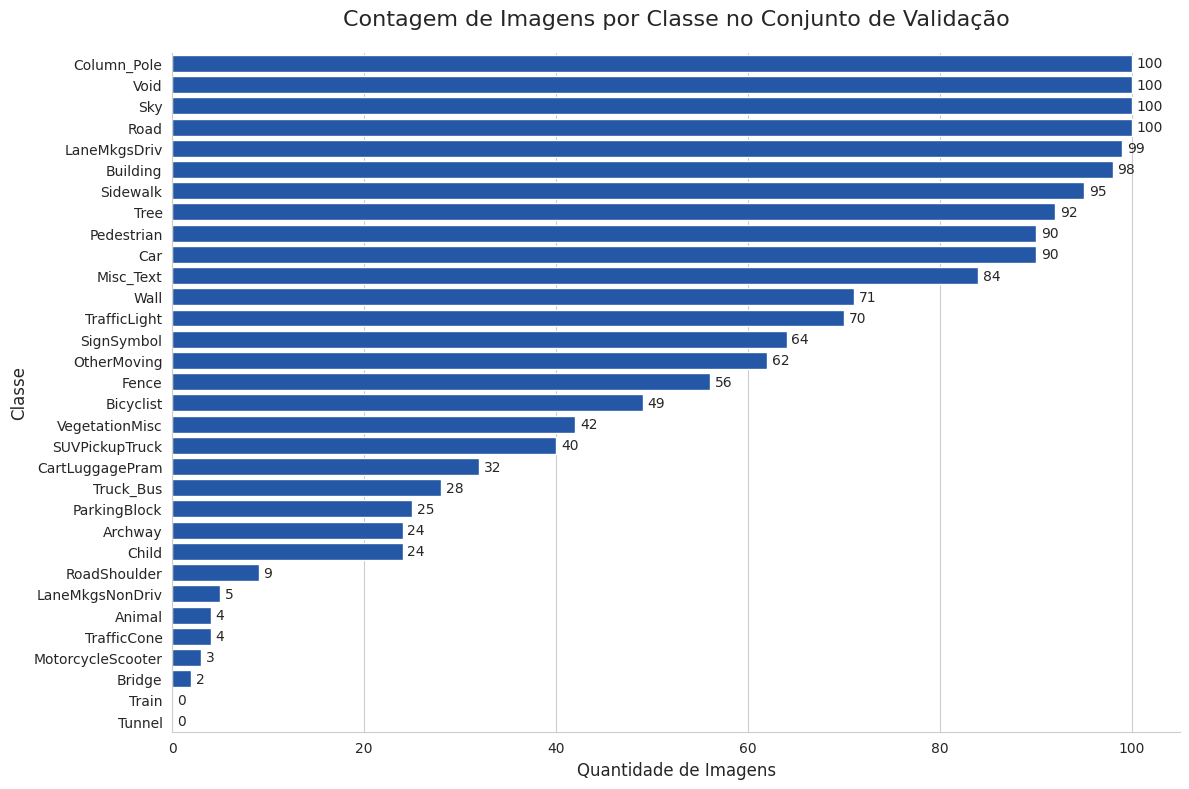

In [20]:
# Ordenando os dados para a visualização no gráfico
df_val_plot = df_val_ranking_images.sort_values(by='Número de Imagens', ascending=False)

# Configurações do estilo e tamanho do gráfico
sns.set_style("whitegrid")
plt.figure(figsize=(12, 8))

# Criação do gráfico de barras horizontais
ax = sns.barplot(x='Número de Imagens', y='Classe', data=df_val_plot, color='#0F52BA', orient='h')

# Adicionando Título e Rótulos
ax.set_title('Contagem de Imagens por Classe no Conjunto de Validação', fontsize=16, pad=20)
ax.set_xlabel('Quantidade de Imagens', fontsize=12)
ax.set_ylabel('Classe', fontsize=12)

# Adicionando os valores exatos ao lado de cada barra
for p in ax.patches:
  width = p.get_width()
  ax.text(width + 0.5,
          p.get_y() + p.get_height() / 2.,
          f'{int(width)}',
          ha='left',
          va='center',
          fontsize=10)

# Removendo as bordas superior e direita do gráfico para um visual mais limpo
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Ajustando o layout e exibindo o gráfico
plt.tight_layout()
plt.show()

## 8. Identificação de imagens duplicadas

## 8.1 Investigação das duplicatas por MD5 olhando todos os metadados

In [21]:
def hash_file(filepath):
    """Calculates the MD5 hash of a file."""
    hasher = hashlib.md5()
    with open(filepath, 'rb') as f:
        while chunk := f.read(4096):
            hasher.update(chunk)
    return hasher.hexdigest()

def find_exact_duplicate_images(directory):
    """Finds exact duplicate images in a directory using cryptographic hashing."""
    hashes = {}
    duplicates = []

    for filename in os.listdir(directory):
        filepath = os.path.join(directory, filename)
        if os.path.isdir(filepath):
            continue  # Skip directories
        try:
            file_hash = hash_file(filepath)
            if file_hash in hashes:
                duplicates.append((hashes[file_hash], filepath))
            else:
                hashes[file_hash] = filepath
        except Exception as e:
            print(f"Erro ao processar o arquivo {filepath}: {e}")

    return duplicates

# Directories to check for exact duplicates
image_directories_to_check = [
    dir_test,
    dir_train,
    dir_val,
    dir_test_labels,
    dir_train_labels,
    dir_val_labels
]

all_exact_duplicates = []
print("Verificando imagens duplicadas exatas:")
for directory in image_directories_to_check:
    print(f"Verificando diretório: {directory}")
    exact_duplicates_in_dir = find_exact_duplicate_images(directory)
    all_exact_duplicates.extend(exact_duplicates_in_dir)

if all_exact_duplicates:
    print("\nImagens duplicadas exatas encontradas:")
    df_exact_duplicates = pd.DataFrame(all_exact_duplicates, columns=['Imagem 1', 'Imagem 2'])
    display(df_exact_duplicates)
else:
    print("\nNão foram encontradas imagens duplicadas exatas em nenhum dos diretórios.")

Verificando imagens duplicadas exatas:
Verificando diretório: /content/camvid/CamVid/test
Verificando diretório: /content/camvid/CamVid/train
Verificando diretório: /content/camvid/CamVid/val
Verificando diretório: /content/camvid/CamVid/test_labels
Verificando diretório: /content/camvid/CamVid/train_labels
Verificando diretório: /content/camvid/CamVid/val_labels

Não foram encontradas imagens duplicadas exatas em nenhum dos diretórios.


## 8.2 Investigação de Duplicatas por SHA256 olhando somente para os pixeis da imagem

In [22]:
def hash_image_pixels(filepath):
    """Calculates the SHA256 hash of the pixel content of an image."""
    try:
        with Image.open(filepath) as img:
            # Use ImageOps.exif_transpose to handle image orientation
            img = ImageOps.exif_transpose(img)
            # Convert to RGB to ensure consistent channel order and number
            img = img.convert('RGB')
            # Get pixel data as bytes
            img_bytes = np.array(img).tobytes()
            # Calculate SHA256 hash
            hasher = hashlib.sha256()
            hasher.update(img_bytes)
            return hasher.hexdigest()
    except Exception as e:
        print(f"Erro ao processar a imagem {filepath}: {e}")
        return None

def find_exact_pixel_duplicates(root_dir):
    """Finds exact duplicate PNG images based on pixel content recursively."""
    hash_to_filepaths = defaultdict(list)
    print(f"Scanning directory: {root_dir}")

    for root, _, files in os.walk(root_dir):
        for filename in files:
            if filename.lower().endswith('.png'):
                filepath = os.path.join(root, filename)
                img_hash = hash_image_pixels(filepath)
                if img_hash:
                    hash_to_filepaths[img_hash].append(filepath)

    duplicate_pairs = []
    for filepaths in hash_to_filepaths.values():
        if len(filepaths) > 1:
            # Generate unique pairs for files with the same hash
            for i in range(len(filepaths)):
                for j in range(i + 1, len(filepaths)):
                    filepath1 = filepaths[i]
                    filepath2 = filepaths[j]

                    # Determine the 'pasta' name
                    pasta1 = "other"
                    for special_folder in ["train", "test", "val"]:
                        if f"/{special_folder}/" in filepath1:
                            pasta1 = special_folder
                            break
                    if pasta1 == "other":
                         pasta1 = os.path.basename(os.path.dirname(filepath1))


                    duplicate_pairs.append({
                        'pasta': pasta1,
                        'Imagem 1': os.path.basename(filepath1),
                        'Imagem 2': os.path.basename(filepath2)
                    })

    return duplicate_pairs

# Specify the root directory to scan (replace with your dataset path)
root_directory = "/content/camvid/CamVid"

duplicate_results = find_exact_pixel_duplicates(root_directory)

if duplicate_results:
    print("\nExact duplicate images found based on pixel content:")
    df_duplicates_pixel = pd.DataFrame(duplicate_results)

    # Sort the DataFrame
    df_duplicates_pixel = df_duplicates_pixel.sort_values(by=['pasta', 'Imagem 1', 'Imagem 2'], ascending=[True, True, True])

    display(df_duplicates_pixel)

    # Optional: Save to CSV
    # csv_output_path = "pixel_duplicates.csv"
    # df_duplicates_pixel.to_csv(csv_output_path, index=False)
    # print(f"\nDuplicate results saved to {csv_output_path}")

else:
    print("\nNão foram encontradas imagens duplicadas exatas em nenhum dos diretórios..")

Scanning directory: /content/camvid/CamVid

Não foram encontradas imagens duplicadas exatas em nenhum dos diretórios..


## 8.3 Investigação de duplicatas por pHash

---



In [23]:
def find_duplicate_images(directory, threshold_percentage=98):
    hashes = {}
    similar_images = []

    for filename in os.listdir(directory):
        filepath = os.path.join(directory, filename)
        if os.path.isdir(filepath):
            continue  # Skip directories
        try:
            with Image.open(filepath) as img:
                img_hash = imagehash.phash(img)
                for existing_filepath, existing_hash in hashes.items():
                     # Calculate Hamming distance
                    hamming_distance = img_hash - existing_hash

                    # Calculate similarity percentage
                    # phash typically uses a hash size of 8x8=64 bits.
                    max_distance = 64
                    similarity_percentage = ((max_distance - hamming_distance) / max_distance) * 100

                    if similarity_percentage >= threshold_percentage:
                         similar_images.append({
                             'Imagem 1': os.path.basename(existing_filepath), # Extract only filename
                             'Imagem 2': os.path.basename(filepath), # Extract only filename
                             'Similaridade (%)': similarity_percentage,
                             'Nome_Pasta': os.path.basename(directory)
                             })

                hashes[filepath] = img_hash # Add the current image hash to the dictionary

        except Exception as e:
            print(f"Erro ao processar a imagem {filepath}: {e}")

    return similar_images

# Directories to check for duplicates
image_directories_to_check = [
    dir_test,
    dir_train,
    dir_val,
]

all_duplicates = []
print("Verificando imagens similares:")
for directory in image_directories_to_check:
    print(f"Verificando diretório: {directory}")
    duplicates_in_dir = find_duplicate_images(directory, threshold_percentage=100)
    all_duplicates.extend(duplicates_in_dir)

if all_duplicates:
    print("\nImagens muito similares (>= 100% de similaridade) foram encontradas:")
    df_duplicates = pd.DataFrame(all_duplicates)
    # Reorder columns
    df_duplicates = df_duplicates[['Nome_Pasta', 'Imagem 1', 'Imagem 2', 'Similaridade (%)']]
    display(df_duplicates)
else:
    print("\nNão foram encontradas imagens muito similares (>= 100% de similaridade) em nenhum dos diretórios.")

Verificando imagens similares:
Verificando diretório: /content/camvid/CamVid/test
Verificando diretório: /content/camvid/CamVid/train
Verificando diretório: /content/camvid/CamVid/val

Imagens muito similares (>= 100% de similaridade) foram encontradas:


,Nome_Pasta,Imagem 1,Imagem 2,Similaridade (%)
0,test,Seq05VD_f01980.png,Seq05VD_f02070.png,100.0
1,test,Seq05VD_f01980.png,Seq05VD_f02610.png,100.0
2,test,Seq05VD_f02070.png,Seq05VD_f02610.png,100.0
3,test,0016E5_08127.png,0016E5_08125.png,100.0
4,test,Seq05VD_f02640.png,Seq05VD_f02580.png,100.0
...,...,...,...,...
71,val,Seq05VD_f02340.png,Seq05VD_f02310.png,100.0
72,val,Seq05VD_f02340.png,Seq05VD_f02280.png,100.0
73,val,Seq05VD_f02310.png,Seq05VD_f02280.png,100.0
74,val,0001TP_009270.png,0001TP_009300.png,100.0


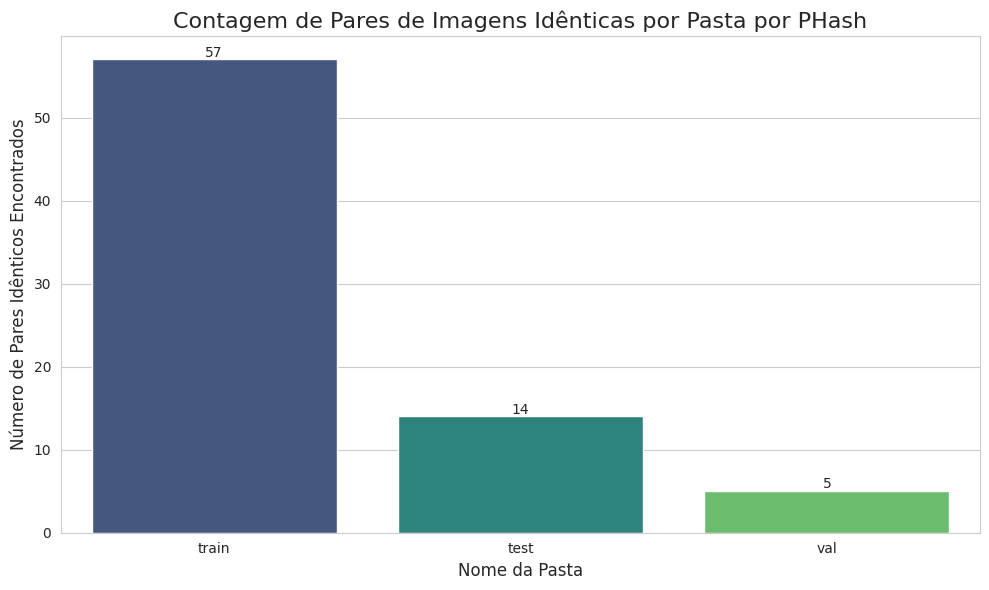

In [24]:
if not df_duplicates.empty:

    contagem_por_pasta = df_duplicates['Nome_Pasta'].value_counts()

    # Criar o gráfico
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x=contagem_por_pasta.index, y=contagem_por_pasta.values, palette='viridis', hue=contagem_por_pasta.index, legend=False)


    plt.title('Contagem de Pares de Imagens Idênticas por Pasta por PHash', fontsize=16)
    plt.xlabel('Nome da Pasta', fontsize=12)
    plt.ylabel('Número de Pares Idênticos Encontrados', fontsize=12)
    plt.xticks(rotation=0)


    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center',
                    xytext=(0, 5),
                    textcoords='offset points')

    plt.tight_layout()
    plt.show()
else:
    print("Nenhuma duplicata encontrada para plotar o gráfico.")

# Configuraçãp do Pipeline de Segmentação

In [25]:
# Diretórios
DIR_TRAIN_IMG = "/content/camvid/CamVid/train"
DIR_TRAIN_MSK = "/content/camvid/CamVid/train_labels"
DIR_VAL_IMG = "/content/camvid/CamVid/val"
DIR_VAL_MSK = "/content/camvid/CamVid/val_labels"
DIR_TEST_IMG = "/content/camvid/CamVid/test"
DIR_TEST_MSK = "/content/camvid/CamVid/test_labels"
PATH_CLASS_DICT = "/content/camvid/CamVid/class_dict.csv"

#Configurações do Modelo e Treinamento

ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else 'cpu')

#Hiperparâmetros

LR = 0.0001
NUM_EP = 25
BATCH_SIZE = 8
WEIGHT_DECAY = 1e-6
PATIENCE_SCHEDULER = 3
PATIENCE_EARLY_STOPPING = 5
FACTOR = 0.5
LAMBDA = 0.3

# Dimensões da Imagem
IMG_HEIGHT = 320
IMG_WIDTH = 480

print(f"Dispositivo selecionado: {DEVICE}")
print(f"Encoder do modelo: {ENCODER}")
print(f"Épocas: {NUM_EP}, Batch Size: {BATCH_SIZE}, Learning Rate: {LR}")

Dispositivo selecionado: cpu
Encoder do modelo: resnet50
Épocas: 25, Batch Size: 8, Learning Rate: 0.0001


# Preparação dos Dados

- Carregamento do Datset do Dataset CamVid
- Mapeamento de Cores para clases

In [26]:
# Carregar e Processar o Mapeamento de Classes
def load_class_mapping(filepath):

  df = pd.read_csv(filepath)
  class_names = df['name'].tolist()

  # Cria um array (R,G,B) para cada classe

  rgb_values = df[['r', 'g','b']].values

  # Mapeamento de (R,G,B) -> ID da Classe

  rgb_to_class_id = {tuple(rgb): idx for idx, rgb in enumerate(rgb_values)}

  num_classes = len(class_names)

  return rgb_to_class_id, class_names, num_classes, rgb_values

#  Carrega os mapeamentos

rgb_to_class_id, CLASS_NAMES, NUM_CLASSES, RGB_VALUES = load_class_mapping(PATH_CLASS_DICT)

print(f"Número de Classes: {NUM_CLASSES}")
print("Nomes das Classes:")
print(CLASS_NAMES)
print("\nMapeamento de Cores para Classes:")
print(rgb_to_class_id)


# Função para converter Máscara RGB em Máscara de Classes

def mask_to_class_id(mask_rgb, rgb_to_class_id):
    """Converte uma máscara RGB em uma máscara de ID de classe."""

    mask_indices = np.zeros((mask_rgb.shape[0], mask_rgb.shape[1]), dtype=np.uint8)

    for rgb_tuple, class_id in rgb_to_class_id.items():
        mask_indices[np.all(mask_rgb == rgb_tuple, axis=-1)] = class_id

    return mask_indices

# Classe de Dataset customizada do PyTorch

class CamVidDataset(Dataset):

  def __init__(self, image_dir, mask_dir, rgb_to_class_id, augmentations=None):
    self.image_dir = image_dir
    self.mask_dir = mask_dir
    self.rgb_to_class_id = rgb_to_class_id
    self.augmentations = augmentations

    # Pega todos os nomes de arquivos de imagem
    self.image_files = os.listdir(image_dir)

    self.image_files = [file for file in self.image_files if file.lower().endswith(('.jpg', '.jpeg', '.png'))]


  def __len__(self):
    # Retorna o número total de imagens
    return len(self.image_files)


  def __getitem__(self, idx):
    # Pega o nome do arquivo da imagem
    img_file = self.image_files[idx]
    img_path = os.path.join(self.image_dir, img_file)

    # O CamVid usa nomes correspondentes para imagens e máscaras
    base_name, _ = os.path.splitext(img_file)
    mask_filename = base_name + "_L.png"
    mask_path = os.path.join(self.mask_dir, mask_filename)

    # Carrega a imagem e a máscara usando OpenCV
    image = cv2.imread(img_path)
    if image is None:
        raise FileNotFoundError(f"Imagem não encontrada: {img_path}")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask_rgb = cv2.imread(mask_path)
    if mask_rgb is None:
        raise FileNotFoundError(f"Máscara não encontrada: {mask_path}")
    mask_rgb = cv2.cvtColor(mask_rgb, cv2.COLOR_BGR2RGB)

    # Converte máscara RGB → IDs de classe
    mask_indices = mask_to_class_id(mask_rgb, self.rgb_to_class_id)

    # Aplica augmentations (caso existam)
    if self.augmentations:
        augmented = self.augmentations(image=image, mask=mask_indices)
        image = augmented['image']
        mask_indices = augmented['mask']

    # Retorna os tensores
    return image, torch.as_tensor(mask_indices, dtype=torch.long)







Número de Classes: 32
Nomes das Classes:
['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole', 'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock', 'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone', 'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall']

Mapeamento de Cores para Classes:
{(np.int64(64), np.int64(128), np.int64(64)): 0, (np.int64(192), np.int64(0), np.int64(128)): 1, (np.int64(0), np.int64(128), np.int64(192)): 2, (np.int64(0), np.int64(128), np.int64(64)): 3, (np.int64(128), np.int64(0), np.int64(0)): 4, (np.int64(64), np.int64(0), np.int64(128)): 5, (np.int64(64), np.int64(0), np.int64(192)): 6, (np.int64(192), np.int64(128), np.int64(64)): 7, (np.int64(192), np.int64(192), np.int64(128)): 8, (np.int64(64), np.int64(64), np.int64(128)): 9, (np.int64(128), np.int64(0), np.int

# Aumento de Dados

- Rotações e Inversões
- Ajustes de Cor e Desfoque

In [27]:
# Pepeline de Aumento para TREINO

def get_train_augs(height, width):
    return A.Compose([
        # Redimensiona para o tamanho definido
        A.Resize(height=height, width=width, interpolation=cv2.INTER_NEAREST),

        # --- Rotações e Inversões ---
        A.HorizontalFlip(p=0.5), # Inversão horizontal
        A.Rotate(limit=15, p=0.5, border_mode=cv2.BORDER_CONSTANT, value=0), # Rotação leve

        # --- Ajustes de Cor e Desfoque
        A.OneOf([
            A.GaussianBlur(blur_limit=(3, 7), p=0.5), # Desfoque Gaussiano
            A.MotionBlur(blur_limit=(3, 7), p=0.5), # Desfoque de Movimento
        ], p=0.3),

        A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.3), # Ajuste de Cor

        # Normalização e conversão para Tensor PyTorch
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ])

# Pipeline de Aumento para VALIDAÇÃO/TESTE

def get_val_augs(height, width):
    return A.Compose([
        A.Resize(height=height, width=width, interpolation=cv2.INTER_NEAREST),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ])


# Criação do Modelo (U-Net)

- O Modelo: A Arquitetura U-Net
- Modelo: Encoders Pré-treinados ResNet-50
- Transfer Learning

In [28]:
def create_model(encoder_name, encoder_weights, num_classes):
    model = smp.Unet(
        encoder_name=encoder_name,
        encoder_weights=encoder_weights,
        in_channels=3,
        classes=num_classes,
        activation=None
    )
    return model



# FUNÇÃO DE PERDA (Loss) E MÉTRICAS

- Loss: Dice + Focal Loss" (com LAMBDA)
- Métricas: IoU, Acurácia e Coeficiente Dice

In [29]:
from math import comb
# Loss Combinada (Dice + Focal)

class CombinedDiceFocalLoss(nn.Module):
    def __init__(self, lambda_weight=0.5, num_classes=21):
        super().__init__()
        self.lambda_weight = lambda_weight
        self.num_classes = num_classes

    def forward(self, inputs, targets):
        """
        inputs: saída do modelo, shape [B, C, H, W]
        targets: máscara de classes, shape [B, H, W]
        """
        # Focal Loss
        inputs_flat = inputs.permute(0,2,3,1).reshape(-1, self.num_classes)
        targets_flat = targets.view(-1)
        focal_loss = F.cross_entropy(inputs_flat, targets_flat)

        # Dice Loss (multiclasse)
        inputs_soft = F.softmax(inputs, dim=1)
        dice_loss = 0.0
        for c in range(self.num_classes):
            input_c = inputs_soft[:, c, :, :]
            target_c = (targets == c).float()
            intersection = (input_c * target_c).sum()
            union = input_c.sum() + target_c.sum()
            dice_loss += 1 - (2 * intersection + 1e-6) / (union + 1e-6)
        dice_loss /= self.num_classes

        # Combina
        loss = self.lambda_weight * dice_loss + (1 - self.lambda_weight) * focal_loss
        return loss

# Métricas de Avaliação (IoU, Accuracy, Dice)
from segmentation_models_pytorch.utils import metrics

def get_metrics(num_classes):
    metrics_list = [
        metrics.IoU(threshold=0.5),
        metrics.Accuracy(threshold=0.5),
        metrics.Fscore(threshold=0.5),
    ]

    metric_names = ['IoU', 'Accuracy', 'Dice']
    return metrics_list, metric_names

# CALLBACKS (Scheduler e Early Stopping)

-  optim: otimizador Adam
- Scheduler: reduz LR quando a métrica de validação não melhora
- early_stopping: interrompe o treinamento se não houver melhora

In [30]:
# Classe EarlyStopping

class EarlyStopping:

    def __init__(self, patience=5, min_delta=0, verbose=True):
        self.patience = patience
        self.min_delta = min_delta # Mudança mínima para ser considerada melhoria
        self.verbose = verbose
        self.counter = 0
        self.best_loss = np.inf
        self.early_stop = False

    def __call__(self, val_loss, model, model_path): # <--- DEFINIÇÃO CORRETA
        # Se a perda de validação for melhor (menor)
        if self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            # Salva o melhor modelo
            if self.verbose:
                print(f"Val loss melhorou ({self.best_loss:.6f}). Salvando modelo...")
            torch.save(model.state_dict(), model_path)

        # Se a perda não for melhor
        else:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping: {self.counter} de {self.patience} épocas sem melhoria.")
            if self.counter >= self.patience:
                print("--- Early stopping ativado! ---")
                self.early_stop = True





# Funções de Treinamento e Validação (O "Loop")

In [31]:
# Loop de Treino

def train_epoch (model, loader, optimizer, loss_fn, device):
  model.train()
  running_loss = 0.0

  # Cria um barra de progresso

  loop = tqdm(loader, desc="Treinamento", leave=False)

  for images, masks in loop:
    images = images.to(device, non_blocking=True)
    masks = masks.to(device, non_blocking=True)


    # 1. Zera os gradientes
    optimizer.zero_grad()
    # 2. Forward pass (previsão)
    outputs = model(images)
    # 3. Calcula a Loss
    loss = loss_fn(outputs, masks)
    # 4. Backward pass (calcula gradientes)
    loss.backward()
    # 5. Atualiza os pesos
    optimizer.step()

    running_loss += loss.item()

    # Atualiza a barra de progresso
    loop.set_postfix(loss=loss.item())

  return running_loss / len(loader)

# Loop de VALIDAÇÃO

def validate_epoch (model, loader, loss_fn, device, metric_names, num_classes, metrics):
  model.eval()
  running_loss = 0.0

  metric_values = {metric_name: 0.0 for metric_name in metric_names}

  # Cria um barra de progresso

  loop = tqdm(loader, desc="Validação", leave=False)

  # Desativa o cálculo de gradientes para economizar memória
  with torch.no_grad():
    for images, masks in loop:
      images = images.to(device, non_blocking=True)
      masks = masks.to(device, non_blocking=True)

      # Forward pass
      outputs = model(images)

      # Calcula a Loss
      loss = loss_fn(outputs, masks)
      running_loss += loss.item()

      # Calcula Métricas
      preds = torch.argmax(outputs, dim=1)

      for i, metric_fn in enumerate(metrics):
        metric_val = metric_fn(preds, masks)
        metric_values[metric_names[i]] += metric_val.item()

      loop.set_postfix(loss=loss.item())

    avg_loss = running_loss / len(loader)

    # Calcula a média das métricas
    for name in metric_names:
        metric_values[name] /= len(loader)

    return avg_loss, metric_values




# Treinamento do Modelo

In [ ]:
# Instanciar Datasets e DataLoaders

train_augs = get_train_augs(IMG_HEIGHT, IMG_WIDTH)
val_augs = get_val_augs(IMG_HEIGHT, IMG_WIDTH)



train_dataset = CamVidDataset(DIR_TRAIN_IMG, DIR_TRAIN_MSK, rgb_to_class_id, augmentations=train_augs)
val_dataset = CamVidDataset(DIR_VAL_IMG, DIR_VAL_MSK, rgb_to_class_id, augmentations=val_augs)

# DataLoaders: Gerenciam o carregamento em lote (batch) e embaralhamento
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)
print(f"DataLoaders criados. Treino: {len(train_loader)} lotes. Validação: {len(val_loader)} lotes.")

#  Instanciar Modelo, Loss, Otimizador, Scheduler, EarlyStopping ---

# Modelo
model = create_model(ENCODER,"imagenet",NUM_CLASSES)
model.to(DEVICE)

# Loss
loss_fn = CombinedDiceFocalLoss(lambda_weight=LAMBDA, num_classes=NUM_CLASSES)
loss_fn.to(DEVICE)

# Métricas
metrics_list, metrics_names = get_metrics(NUM_CLASSES)
# Move métricas para o dispositivo
for m in metrics_list:
    m.to(DEVICE)

# Otimizador)
optimizer = Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

# Scheduler
scheduler = ReduceLROnPlateau(
    optimizer,
    mode='min', # Reduz LR quando a 'val_loss' (métrica monitorada) para de cair
    factor=FACTOR,
    patience=PATIENCE_SCHEDULER
)

# Early Stopping
BEST_MODEL_PATH = f"best_model_{ENCODER}.pth"
early_stopper = EarlyStopping(
    patience=PATIENCE_EARLY_STOPPING,
    verbose=True
)

#  O Loop de Treinamento Principal
history = {
    "train_loss": [],
    "val_loss": [],
}
for name in metrics_names:
    history[name] = []

start_time = time.time()

print("\nIniciando o loop de treinamento...")

for epoch in range(1, NUM_EP + 1):
    print(f"\n--- Época {epoch}/{NUM_EP} ---")

    # Treino
    train_loss = train_epoch(model, train_loader, optimizer, loss_fn, DEVICE)
    history["train_loss"].append(train_loss)

    # Validação
    val_loss, val_metrics = validate_epoch(model, val_loader, loss_fn, DEVICE, metrics_names, NUM_CLASSES, metrics_list)
    history["val_loss"].append(val_loss)
    for name in metrics_names:
        history[name].append(val_metrics[name])

    # --- Logs da Época ---
    print(f"Época {epoch:02d} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")
    metrics_log = " | ".join([f"Val {name}: {val_metrics[name]:.4f}" for name in metrics_names])
    print(metrics_log)

    # --- Atualiza Scheduler e Early Stopping ---

    # O Scheduler monitora a 'val_loss'
    scheduler.step(val_loss)

    # O EarlyStopping monitora a 'val_loss' e salva o melhor modelo
    early_stopper(val_loss, model, BEST_MODEL_PATH)

    if early_stopper.early_stop:
        break # Interrompe o treinamento

end_time = time.time()
total_time = (end_time - start_time) / 60
print(f"\n--- Treinamento Concluído em {total_time:.2f} minutos ---")
print(f"Melhor modelo salvo em: {BEST_MODEL_PATH}")
print(f"Melhor Val Loss: {early_stopper.best_loss:.6f}")

DataLoaders criados. Treino: 47 lotes. Validação: 13 lotes.


/tmp/ipython-input-1653708220.py:10: UserWarning: Argument(s) 'value' are not valid for transform Rotate
  A.Rotate(limit=15, p=0.5, border_mode=cv2.BORDER_CONSTANT, value=0), # Rotação leve
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]


Iniciando o loop de treinamento...

--- Época 1/25 ---


Treinamento:   0%|          | 0/47 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Época 01 | Train Loss: 2.163818 | Val Loss: 1.817533
Val IoU: 13.8172 | Val Accuracy: 0.0023 | Val Dice: 1.8645
Val loss melhorou (1.817533). Salvando modelo...

--- Época 2/25 ---


Época 02 | Train Loss: 1.695738 | Val Loss: 1.505182
Val IoU: 14.2083 | Val Accuracy: 0.0022 | Val Dice: 1.8682
Val loss melhorou (1.505182). Salvando modelo...

--- Época 3/25 ---


Treinamento:  57%|█████▋    | 27/47 [19:29<13:55, 41.75s/it, loss=1.38]

In [ ]:
!pip install --upgrade albumentations

In [ ]:
# -------------------------------------------------------------------
# VISUALIZAÇÃO DOS RESULTADOS
# Especificação: "Visualização: Matplotlib"
# -------------------------------------------------------------------

# ---  Plotar Gráficos de Treinamento (Loss e Métricas) ---

print("\n--- Gerando gráficos de resultados ---")

# Quantidade de épocas que realmente rodaram
epochs_ran = len(history['train_loss'])
epochs_range = range(1, epochs_ran + 1)

plt.figure(figsize=(15, 6))

# Gráfico de Loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history['train_loss'], 'b-', label='Train Loss')
plt.plot(epochs_range, history['val_loss'], 'r-', label='Val Loss')
plt.title('Loss de Treino e Validação')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Gráfico de Métricas (IoU e Dice)
plt.subplot(1, 2, 2)
plt.plot(epochs_range, history['IoU'], 'g-', label='Val IoU')
plt.plot(epochs_range, history['Dice'], 'm-', label='Val Dice (F1)')
plt.plot(epochs_range, history['Accuracy'], 'c-', label='Val Accuracy')
plt.title('Métricas de Validação (IoU, Dice, Accuracy)')
plt.xlabel('Época')
plt.ylabel('Métrica')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# ---  Avaliação no Conjunto de TESTE (Opcional, mas recomendado) ---


print("\n--- Avaliando o melhor modelo no conjunto de TESTE ---")

# 1. Criar dataset e dataloader de teste
test_augs = get_val_augs(IMG_HEIGHT, IMG_WIDTH) # Sem aumento de dados, só resize/normalize
test_dataset = CamVidDataset(DIR_TEST_IMG, DIR_TEST_MSK, rgb_to_class_id, augmentations=test_augs)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# 2. Carregar o melhor modelo
# (Precisamos recriar a arquitetura antes de carregar os pesos)
model_best = create_model(ENCODER, ENCODER_WEIGHTS, NUM_CLASSES)
model_best.load_state_dict(torch.load(BEST_MODEL_PATH))
model_best.to(DEVICE)

# 3. Executar a avaliação (usando a mesma função 'val_epoch')
test_loss, test_metrics = validate_epoch(
    model_best,
    test_loader,
    loss_fn,
    DEVICE,
    metrics_names,
    NUM_CLASSES,
    metrics_list
)

print("\n--- Resultados Finais no Conjunto de TESTE ---")
print(f"Test Loss: {test_loss:.6f}")
metrics_log_test = " | ".join([f"Test {name}: {test_metrics[name]:.4f}" for name in metrics_names])
print(metrics_log_test)

In [ ]:
# Substitua sua função 'validate_epoch' inteira por esta:

def validate_epoch(model, loader, loss_fn, device, metric_names, num_classes, metrics):
    model.eval()
    running_loss = 0.0

    # Inicializa os valores das métricas
    metric_values = {name: 0.0 for name in metric_names}

    # --- NOVO: Listas para a Matriz de Confusão ---
    all_preds_list = []
    all_masks_list = []

    loop = tqdm(loader, desc="Validação/Teste", leave=False)

    # Desativa o cálculo de gradientes
    with torch.no_grad():
        for images, masks in loop:
            images = images.to(device, non_blocking=True)
            masks = masks.to(device, non_blocking=True)

            # Forward pass
            outputs = model(images)

            # Calcula a Loss
            loss = loss_fn(outputs, masks)
            running_loss += loss.item()

            # (Batch, Classes, H, W) -> (Batch, H, W)
            preds = torch.argmax(outputs, dim=1)


            all_preds_list.append(preds.cpu().numpy().flatten())
            all_masks_list.append(masks.cpu().numpy().flatten())

            # Calcula Métricas (IoU, Dice, etc.)
            for i, metric_fn in enumerate(metrics):
                metric_val = metric_fn(preds, masks)
                metric_values[metric_names[i]] += metric_val.item()

            loop.set_postfix(loss=loss.item())

    avg_loss = running_loss / len(loader)

    # Calcula a média das métricas
    for name in metric_names:
      if len(loader) > 0:
        metric_values[name] /= len(loader)

    # --- NOVO: Concatena todos os vetores de todos os lotes ---
    all_preds_flat = np.concatenate(all_preds_list)
    all_masks_flat = np.concatenate(all_masks_list)

    # Retorna os valores achatados
    return avg_loss, metric_values, all_preds_flat, all_masks_flat

In [ ]:
# -------------------------------------------------------------------
#  VISUALIZAÇÃO DAS PREVISÕES
# (Opcional, mas muito útil para análise qualitativa)
# -------------------------------------------------------------------

def mask_indices_to_rgb(mask_indices, rgb_values):
    """Converte máscara de classes (H, W) de volta para RGB (H, W, 3)"""
    mask_rgb = np.zeros((*mask_indices.shape, 3), dtype=np.uint8)

    # Itera sobre os IDs das classes
    for class_id in range(len(rgb_values)):
        # Encontra pixels com este ID e pinta com a cor RGB correspondente
        mask_rgb[mask_indices == class_id] = rgb_values[class_id]

    return mask_rgb

def visualize_predictions(model, loader, device, rgb_values, num_images=5):
    """Mostra a Imagem Original, a Máscara Real e a Máscara Prevista"""
    model.eval()
    images_shown = 0

    with torch.no_grad():
        # Pega um lote (batch) do loader
        for images_batch, masks_batch in loader:

            # Move para a GPU
            images_batch = images_batch.to(device)
            # masks_batch já está na CPU, o que é bom para plotar

            # Faz a previsão
            outputs_batch = model(images_batch)

            # Converte logits para predições de classe (IDs)
            # (Batch, C, H, W) -> (Batch, H, W)
            preds_batch = torch.argmax(outputs_batch, dim=1).cpu().numpy()

            # Itera sobre as imagens no lote
            for i in range(images_batch.shape[0]):
                if images_shown >= num_images:
                    break

                # --- Preparação para Plotagem ---

                # 1. Imagem Original
                # Pega a imagem do tensor (C, H, W)
                img_tensor = images_batch[i].cpu().permute(1, 2, 0)
                # Desfaz a normalização (mean/std)
                mean = np.array([0.485, 0.456, 0.406])
                std = np.array([0.229, 0.224, 0.225])
                img_original = (img_tensor.numpy() * std + mean) * 255
                img_original = img_original.astype(np.uint8)

                # 2. Máscara Real (Ground Truth)
                mask_real_indices = masks_batch[i].numpy()
                mask_real_rgb = mask_indices_to_rgb(mask_real_indices, rgb_values)

                # 3. Máscara Prevista
                mask_pred_indices = preds_batch[i]
                mask_pred_rgb = mask_indices_to_rgb(mask_pred_indices, rgb_values)

                # --- Plotagem ---
                plt.figure(figsize=(18, 6))

                plt.subplot(1, 3, 1)
                plt.imshow(img_original)
                plt.title(f"Imagem Original (ID: {images_shown})")
                plt.axis('off')

                plt.subplot(1, 3, 2)
                plt.imshow(mask_real_rgb)
                plt.title("Máscara Real (Gabarito)")
                plt.axis('off')

                plt.subplot(1, 3, 3)
                plt.imshow(mask_pred_rgb)
                plt.title("Previsão do Modelo")
                plt.axis('off')

                plt.show()

                images_shown += 1

            if images_shown >= num_images:
                break

# Visualiza 5 previsões do conjunto de TESTE
print("\n--- Visualizando Previsões do Modelo de Teste ---")
model_best = create_model(ENCODER, ENCODER_WEIGHTS, NUM_CLASSES)
visualize_predictions(model_best, test_loader, DEVICE, RGB_VALUES, num_images=5)


In [ ]:


print("\n--- Avaliando o melhor modelo no conjunto de TESTE ---")

# 1. Criar dataset e dataloader de teste
test_augs = get_val_augs(IMG_HEIGHT, IMG_WIDTH)
test_dataset = CamVidDataset(DIR_TEST_IMG, DIR_TEST_MSK, rgb_to_class_id, augmentations=test_augs)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# 2. Carregar o melhor modelo
model_best = create_model(ENCODER, ENCODER_WEIGHTS, NUM_CLASSES) # Use a versão com 3 argumentos
model_best.load_state_dict(torch.load(BEST_MODEL_PATH))
model_best.to(DEVICE)

# 3. Executar a avaliação (usando a mesma função 'validate_epoch')
test_loss, test_metrics, all_preds_flat, all_masks_flat = validate_epoch(
    model_best,
    test_loader,
    loss_fn,
    DEVICE,
    metrics_names,
    NUM_CLASSES,
    metrics_list
)

print("\n--- Resultados Finais no Conjunto de TESTE ---")
print(f"Test Loss: {test_loss:.6f}")
metrics_log_test = " | ".join([f"Test {name}: {test_metrics[name]:.4f}" for name in metrics_names])
print(metrics_log_test)


print("\n--- Gerando Matriz de Confusão ---")

# Precisamos da lista 'CLASS_NAMES' que foi definida na PARTE 5
try:
    # 'labels' garante que a matriz tenha o tamanho [num_classes x num_classes]
    # mesmo que algumas classes não apareçam no teste
    cm = confusion_matrix(
        all_masks_flat,  # Eixo Y (Real)
        all_preds_flat,  # Eixo X (Previsto)
        labels=np.arange(len(CLASS_NAMES))
    )

    # 2. Plotar a Matriz de Confusão com Seaborn
    plt.figure(figsize=(16, 13)) # Tamanho ajustado para muitas classes
    ax = sns.heatmap(
        cm,
        annot=True,     # Escreve os números dentro das células
        fmt='d',        # Formato dos números (inteiro 'decimal')
        cmap='Blues',   # Esquema de cores
        xticklabels=CLASS_NAMES,
        yticklabels=CLASS_NAMES
    )

    plt.title('Matriz de Confusão - Conjunto de Teste', fontsize=18)
    plt.xlabel('Classe Prevista', fontsize=14)
    plt.ylabel('Classe Real', fontsize=14)
    plt.xticks(rotation=90) # Gira os rótulos do eixo X
    plt.yticks(rotation=0)  # Deixa os rótulos do eixo Y na horizontal
    plt.tight_layout()
    plt.show()

except NameError as e:
    print(f"Erro ao gerar matriz: {e}")
    print("Certifique-se de que a variável 'CLASS_NAMES' da PARTE 5 foi executada e está disponível.")
except Exception as e:
    print(f"Ocorreu um erro inesperado ao gerar a matriz: {e}")